## Install Libraries

In [3]:
%pip install pandas numpy matplotlib statsmodels scikit-learn xgboost seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import sys
print(sys.executable)


C:\Users\WW\Desktop\Samsung_Stock_Price_Change_Prediction\Model_Building\stock_env\Scripts\python.exe


## Import necassary libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Load Dataset

In [8]:
data = pd.read_csv(r"C:\Users\WW\Desktop\Samsung_Stock_Price_Change_Prediction\Model_Building\Samsung_Stock_Prices.csv")
data.head()

,Date,open,high,low,close,adjclose,volume,ingested_at_utc
0,2019-01-02,39400.0,39400.0,38550.0,38750.0,32363.783203,7847664,2026-02-03 07:06:34.962935+00:00
1,2019-01-03,38300.0,38550.0,37450.0,37600.0,31403.318359,12471493,2026-02-03 07:06:34.962935+00:00
2,2019-01-04,37450.0,37600.0,36850.0,37450.0,31278.039062,14108958,2026-02-03 07:06:34.962935+00:00
3,2019-01-07,38000.0,38900.0,37800.0,38750.0,32363.783203,12748997,2026-02-03 07:06:34.962935+00:00
4,2019-01-08,38000.0,39200.0,37950.0,38100.0,31820.914062,12756554,2026-02-03 07:06:34.962935+00:00


## Data Preprocessing

In [10]:
# Convert Date column to proper Datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)


In [11]:
# checking the rowa and columns of dataset
data.shape

(1740, 7)

In [12]:
data.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 1740 entries, 2019-01-02 to 2026-02-03
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             1739 non-null   float64
 1   high             1739 non-null   float64
 2   low              1739 non-null   float64
 3   close            1739 non-null   float64
 4   adjclose         1739 non-null   float64
 5   volume           1740 non-null   int64  
 6   ingested_at_utc  1740 non-null   str    
dtypes: float64(5), int64(1), str(1)
memory usage: 108.8 KB


In [13]:
# For statistical summary
data.describe()

,open,high,low,close,adjclose,volume
count,1739.000000,1739.000000,1739.000000,1739.000000,1739.000000,1.740000e+03
mean,66408.568143,67073.317999,65746.003450,66392.093157,61594.568555,1.711687e+07
std,16520.934297,16831.372291,16273.770341,16587.296510,17531.900572,8.809985e+06
min,37450.000000,37600.000000,36850.000000,37450.000000,31278.039062,0.000000e+00
25%,55700.000000,56350.000000,55100.000000,55600.000000,51598.808594,1.151836e+07
50%,64100.000000,65000.000000,63800.000000,64500.000000,60435.265625,1.524570e+07
75%,74800.000000,75400.000000,74050.000000,74750.000000,70275.960938,2.083407e+07
max,166200.000000,167500.000000,160200.000000,167500.000000,167500.000000,9.030618e+07


In [14]:
#Checking duplicate values
data.duplicated().sum()

np.int64(3)

In [15]:
# Remove Duplicates and Recheck 
data = data.drop_duplicates()
data.duplicated().sum()

np.int64(0)

In [17]:
# Check for the missing values 
data.isnull().sum()

open               1
high               1
low                1
close              1
adjclose           1
volume             0
ingested_at_utc    0
dtype: int64

In [18]:
# Remove rows with missing values and recheck
data = data.dropna()
data.isnull().sum()

open               0
high               0
low                0
close              0
adjclose           0
volume             0
ingested_at_utc    0
dtype: int64

In [19]:
# Drop unnecassary columns 
data=data.drop(columns=['ingested_at_utc'])

In [20]:
data.head()

,open,high,low,close,adjclose,volume
Date,,,,,,
2019-01-02,39400.0,39400.0,38550.0,38750.0,32363.783203,7847664
2019-01-03,38300.0,38550.0,37450.0,37600.0,31403.318359,12471493
2019-01-04,37450.0,37600.0,36850.0,37450.0,31278.039062,14108958
2019-01-07,38000.0,38900.0,37800.0,38750.0,32363.783203,12748997
2019-01-08,38000.0,39200.0,37950.0,38100.0,31820.914062,12756554


#### Create Log_Return (Target Variable)

In [21]:
data['Log_Return'] = np.log(data['adjclose'] / data['adjclose'].shift(1))

In [23]:
# Remove first missing row (The first row will be NaN because there is no previous day.)
data=data.dropna()

In [24]:
data[['adjclose','Log_Return']].head()

,adjclose,Log_Return
Date,,
2019-01-03,31403.318359,-0.030126
2019-01-04,31278.039062,-0.003997
2019-01-07,32363.783203,0.034124
2019-01-08,31820.914062,-0.016916
2019-01-09,33073.714844,0.038615


## Exploratory Data Analysis(EDA)

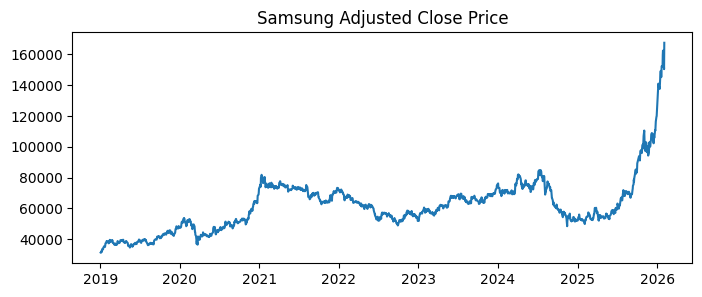

In [36]:
#Plot adjusted close (Just for understanding)
plt.figure(figsize=(8,3))
plt.plot(data['adjclose'])
plt.title("Samsung Adjusted Close Price")
plt.show()

#### Plot Log_Returns

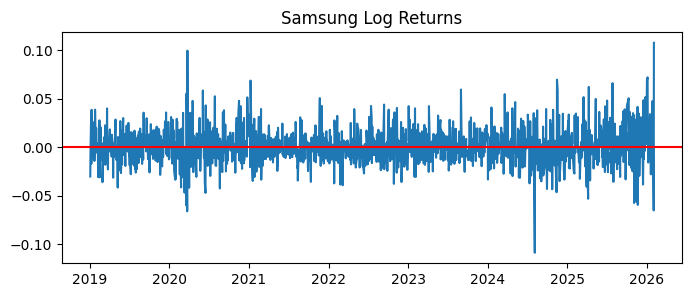

In [37]:
plt.figure(figsize=(8,3))
plt.plot(data['Log_Return'])
plt.title("Samsung Log Returns")
plt.axhline(0, color='red')
plt.show()

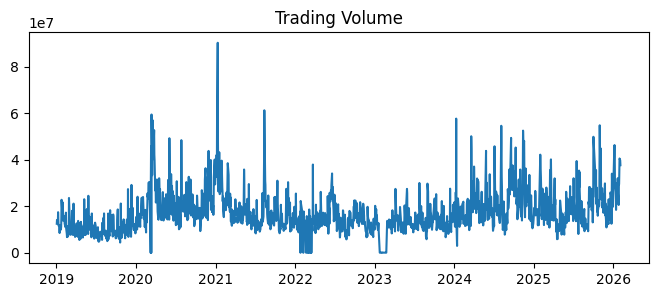

In [49]:
# Plot the volume 
plt.figure(figsize=(8,3))
plt.plot(data['volume'])
plt.title("Trading Volume")
plt.show()

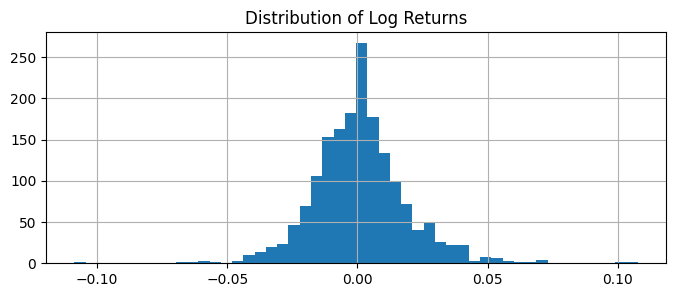

In [50]:
# Distribution of Log_Returns
plt.figure(figsize=(8,3))
data['Log_Return'].hist(bins=50)
plt.title("Distribution of Log Returns")
plt.show()


In [43]:
# Summary Statictics
data['Log_Return'].describe()

count    1735.000000
mean        0.000948
std         0.017760
min        -0.108716
25%        -0.009748
50%         0.000000
75%         0.009969
max         0.107685
Name: Log_Return, dtype: float64

In [44]:
# Stationary Test
result = adfuller(data['Log_Return'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -40.34659855830766
p-value: 0.0


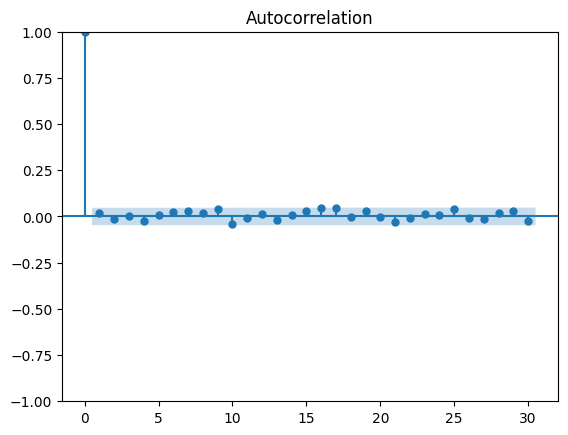

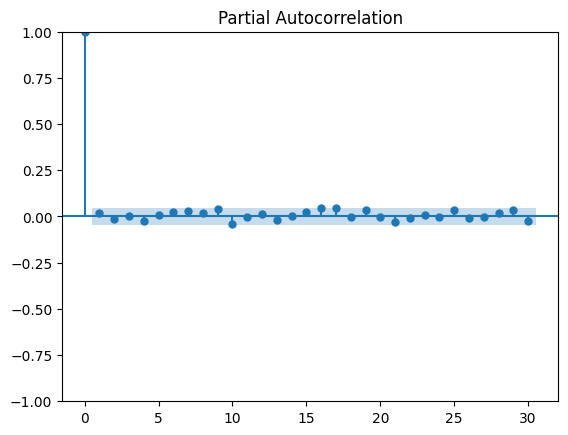

In [54]:
# For check autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Log_Return'], lags=30)
plt.show()

plot_pacf(data['Log_Return'], lags=30)
plt.show()


## Feature Engineering

Create basic lag features.(That are important to ML models)

In [97]:
data['lag_1'] = data['Log_Return'].shift(1)
data['lag_2'] = data['Log_Return'].shift(2)
data['lag_5'] = data['Log_Return'].shift(5)
data['lag_10'] = data['Log_Return'].shift(10)
data['lag_20'] = data['Log_Return'].shift(20)
data['lag_30'] = data['Log_Return'].shift(30)

In [98]:
# Rolling Features 
data['rolling_mean_5'] = data['Log_Return'].shift(1).rolling(5).mean()
data['rolling_std_5']  = data['Log_Return'].shift(1).rolling(5).std()

data['rolling_mean_10'] = data['Log_Return'].shift(1).rolling(10).mean()
data['rolling_std_10']  = data['Log_Return'].shift(1).rolling(10).std()

data['rolling_std_20'] = data['Log_Return'].shift(1).rolling(20).std()
data['rolling_std_30'] = data['Log_Return'].shift(1).rolling(30).std()


In [99]:
data['momentum_10'] = data['adjclose'].shift(1) / data['adjclose'].shift(10) - 1
data['momentum_20'] = data['adjclose'].shift(1) / data['adjclose'].shift(20) - 1

Moving Averages 

In [100]:
data['ma_10'] = data['adjclose'].shift(1).rolling(10).mean()
data['ma_20'] = data['adjclose'].shift(1).rolling(20).mean()

data['ma_ratio_10'] = data['adjclose'].shift(1) / data['ma_10']
data['ma_ratio_20'] = data['adjclose'].shift(1) / data['ma_20']


In [65]:
# Volume based feature
data['volume_lag1'] = data['volume'].shift(1)

In [101]:
data['volume_change'] = data['volume'].pct_change().shift(1)
data['volume_rolling_10'] = data['volume'].shift(1).rolling(10).mean()


In [103]:
# Drop missing values because lag features make null values at the top
data = data.dropna()

In [104]:
data.head()

,open,high,low,close,adjclose,volume,Log_Return,lag_1,lag_2,lag_5,...,rolling_std_20,rolling_std_30,momentum_10,momentum_20,ma_10,ma_20,ma_ratio_10,ma_ratio_20,volume_change,volume_rolling_10
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-06,44000.0,44300.0,43700.0,44000.0,36748.566406,10202544,-0.005666,-0.013468,-0.005559,-0.012753,...,0.016778,0.017113,-0.036997,-0.041170,38585.989453,38523.350586,0.957792,0.959350,-0.179022,10446163.5
2019-03-07,43400.0,44950.0,43400.0,44450.0,37124.406250,11049749,0.010175,-0.005666,-0.013468,0.000000,...,0.016780,0.017067,-0.061834,-0.050701,38423.126172,38433.567383,0.956418,0.956158,-0.038621,10792278.4
2019-03-08,44450.0,44800.0,43800.0,43800.0,36581.515625,7729069,-0.014732,0.010175,-0.005666,-0.035932,...,0.016953,0.017096,-0.053248,-0.037879,38218.503125,38354.223633,0.971373,0.967935,0.083039,10746581.3
2019-03-11,44400.0,44450.0,43650.0,43650.0,36456.246094,10717408,-0.003430,-0.014732,0.010175,-0.005559,...,0.017187,0.017264,-0.071050,-0.022322,37955.416016,38254.000000,0.963802,0.956279,-0.300521,10650087.3
2019-03-12,44300.0,44950.0,44150.0,44650.0,37291.437500,11431977,0.022651,-0.003430,-0.014732,-0.013468,...,0.015871,0.017054,-0.078141,-0.030000,37663.098437,38205.976562,0.967957,0.954203,0.386636,11032250.9


In [107]:
data.shape

(1695, 28)

Define feature matrix and target

In [111]:
data.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 1695 entries, 2019-03-06 to 2026-02-03
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               1695 non-null   float64
 1   high               1695 non-null   float64
 2   low                1695 non-null   float64
 3   close              1695 non-null   float64
 4   adjclose           1695 non-null   float64
 5   volume             1695 non-null   int64  
 6   Log_Return         1695 non-null   float64
 7   lag_1              1695 non-null   float64
 8   lag_2              1695 non-null   float64
 9   lag_5              1695 non-null   float64
 10  lag_10             1695 non-null   float64
 11  rolling_mean_5     1695 non-null   float64
 12  rolling_std_5      1695 non-null   float64
 13  rolling_mean_10    1695 non-null   float64
 14  rolling_std_10     1695 non-null   float64
 15  volume_lag1        1695 non-null   float64
 16  lag_20           

In [112]:
features = [
    'lag_1','lag_2','lag_5','lag_10','lag_20','lag_30',
    'rolling_std_5','rolling_std_10','rolling_std_20','rolling_std_30',
    'momentum_10','momentum_20',
    'ma_ratio_10','ma_ratio_20',
    'volume_lag1','volume_change','volume_rolling_10'
]


In [117]:
# Replace inf/-inf with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows that still have NaN in features or target
data = data.dropna(subset=features + ['Log_Return'])

In [119]:
X = data[features]
y = data['Log_Return']

In [120]:
np.isinf(X).sum().sum(), X.isna().sum().sum()

(np.int64(0), np.int64(0))

## Model Building 

Tme based train/test split

In [125]:
split_index = int(len(data) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


#### Build the RandomForest regressor model

In [135]:


rf_final = RandomForestRegressor(
    n_estimators=800,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features=0.3,
    max_depth=2,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)

rf_pred_final = rf_final.predict(X_test)


#### Evaluating the model

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_rf = mean_absolute_error(y_test, rf_pred_final)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred_final))
r2_rf = r2_score(y_test, rf_pred_final)

direction_accuracy_rf = np.mean(
    np.sign(rf_pred_final) == np.sign(y_test)
)

print("Tuned Random Forest Results:")
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R²:", r2_rf)
print("Directional Accuracy:", direction_accuracy_rf)


Tuned Random Forest Results:
MAE: 0.01729766857933604
RMSE: 0.02321355948603525
R²: -0.00429984469014677
Directional Accuracy: 0.516320474777448


#### Hyperparameter tuning for select best parameters 

In [128]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_param_dist = {
    "n_estimators": [400, 800, 1200, 1600],
    "max_depth": [2, 3, 4, 5, 6, 8, 10, None],
    "min_samples_split": [2, 5, 10, 20, 50],
    "min_samples_leaf": [1, 2, 4, 8, 16],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
    "bootstrap": [True, False],
}

rf_search = RandomizedSearchCV(
    rf,
    param_distributions=rf_param_dist,
    n_iter=200,                      # <-- stronger search
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True,
    return_train_score=True
)

rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
best_rf = rf_search.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best RF params: {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 2, 'bootstrap': True}


In [137]:
rf_final = RandomForestRegressor(
    n_estimators=1600,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_final.fit(X_train, y_train)

# Predict
rf_pred_final = rf_final.predict(X_test)

In [138]:
mae = mean_absolute_error(y_test, rf_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, rf_pred_final))
r2 = r2_score(y_test, rf_pred_final)
direction_acc = np.mean(np.sign(rf_pred_final) == np.sign(y_test))

print("Tuned RF Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
print("Directional Accuracy:", direction_acc)

Tuned RF Results:
MAE: 0.017253235541900856
RMSE: 0.023219618607330572
R²: -0.004824190708248688
Directional Accuracy: 0.5192878338278932


In [131]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)


In [177]:
rf_final = RandomForestRegressor(
    n_estimators=800,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features=0.3,
    max_depth=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_final.fit(X_train, y_train)

# Predict
rf_pred_final = rf_final.predict(X_test)

In [178]:
mae = mean_absolute_error(y_test, rf_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, rf_pred_final))
r2 = r2_score(y_test, rf_pred_final)
direction_acc = np.mean(np.sign(rf_pred_final) == np.sign(y_test))

print("Tuned RF Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
print("Directional Accuracy:", direction_acc)

Tuned RF Results:
MAE: 0.017244584469456137
RMSE: 0.023172425542176436
R²: -0.0007438012920375492
Directional Accuracy: 0.5252225519287834


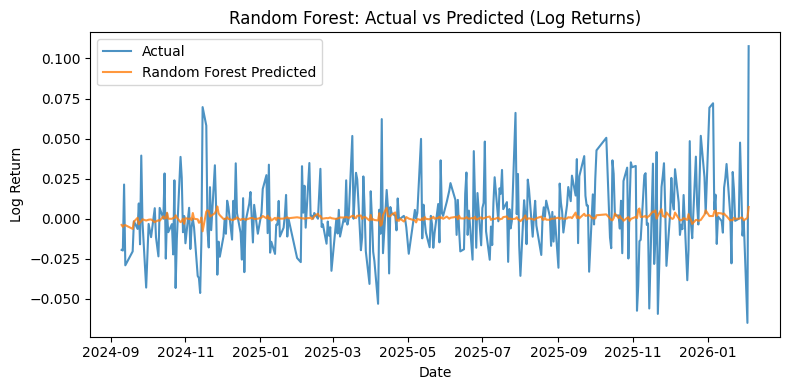

In [264]:
plt.figure(figsize=(8,4))
plt.plot(y_test.index, y_test.values, label="Actual", alpha=0.8)
plt.plot(y_test.index, rf_pred_final, label="Random Forest Predicted", alpha=0.8)
plt.title("Random Forest: Actual vs Predicted (Log Returns)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.tight_layout()
plt.show()

### XGBoost Model

#### Model Building

In [212]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)


In [213]:
mae = mean_absolute_error(y_test, xgb_pred)
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
r2 = r2_score(y_test, xgb_pred)
dir_acc = np.mean(np.sign(xgb_pred) == np.sign(y_test))

print("XGBoost Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
print("Directional Accuracy:", dir_acc)

XGBoost Results:
MAE: 0.017784255991220455
RMSE: 0.023631440760979193
R²: -0.040783309363717546
Directional Accuracy: 0.49554896142433236


#### Hyperparameter tunning for choose best parameters 

In [218]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)


In [219]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_param_dist = {
    "n_estimators": [500, 800, 1200, 1600, 2000],
    "learning_rate": [0.005, 0.01, 0.02, 0.03, 0.05],
    "max_depth": [2, 3, 4, 5],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 3, 5, 7, 10],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_alpha": [0, 0.001, 0.01, 0.1],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0]
}

In [238]:
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=800,   # strong search
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print("Best XGB params:", xgb_search.best_params_)

best_xgb = xgb_search.best_estimator_

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best XGB params: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'n_estimators': 1600, 'min_child_weight': 10, 'max_depth': 2, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}


In [239]:
xgb_final = XGBRegressor(
    objective="reg:squarederror",
    subsample=0.6,
    reg_lambda=0.5,
    reg_alpha=0.01,
    n_estimators=1600,
    min_child_weight=10,
    max_depth=2,
    learning_rate=0.05,
    gamma=0.1,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

# Train
xgb_final.fit(X_train, y_train)

# Predict
xgb_pred_final = xgb_final.predict(X_test)

In [240]:
# Evaluate
mae = mean_absolute_error(y_test, xgb_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred_final))
r2 = r2_score(y_test, xgb_pred_final)
dir_acc = np.mean(np.sign(xgb_pred_final) == np.sign(y_test))

print("Tuned XGBoost Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
print("Directional Accuracy:", dir_acc)

Tuned XGBoost Results:
MAE: 0.017353987579446315
RMSE: 0.023282420456883363
R²: -0.010267015431339788
Directional Accuracy: 0.5074183976261127


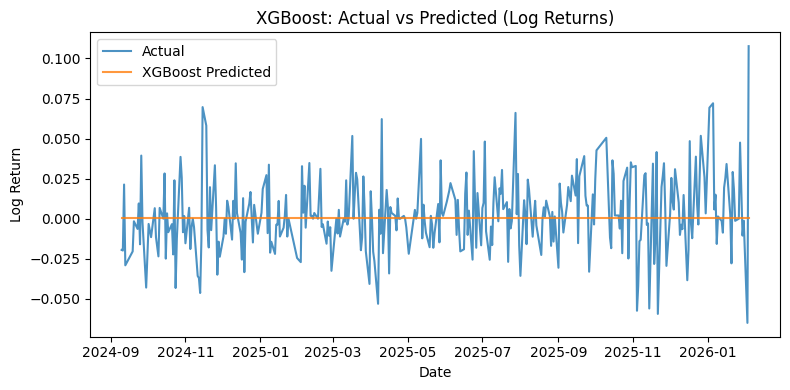

In [266]:
plt.figure(figsize=(8,4))
plt.plot(y_test.index, y_test.values, label="Actual", alpha=0.8)
plt.plot(y_test.index, xgb_pred_final, label="XGBoost Predicted", alpha=0.8)
plt.title("XGBoost: Actual vs Predicted (Log Returns)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.tight_layout()
plt.show()

In [267]:
# Naive baseline: predict today's return as yesterday's return (lag_1)
naive_pred = X_test['lag_1'].values  

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    dir_acc = np.mean(np.sign(y_pred) == np.sign(y_true))
    print(f"{name}: MAE={mae:.6f} RMSE={rmse:.6f} R2={r2:.6f} DirAcc={dir_acc:.3f}")

evaluate("Naive (lag_1)", y_test, naive_pred)
evaluate("Random Forest", y_test, rf_pred_final)
evaluate("XGBoost", y_test, xgb_pred_final)


Naive (lag_1): MAE=0.024261 RMSE=0.031904 R2=-0.897031 DirAcc=0.454
Random Forest: MAE=0.017263 RMSE=0.023233 R2=-0.006024 DirAcc=0.519
XGBoost: MAE=0.017354 RMSE=0.023282 R2=-0.010194 DirAcc=0.507
